# Import

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from datetime import datetime, timedelta, date
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn import preprocessing
import plotly.graph_objects as go
import tensorflow as tf

# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [ ]:
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Load

In [ ]:
df_train = pd.read_csv('../Data/train_time_data_pf.csv', encoding='cp949')

In [ ]:
df_train['STD_DT'] = df_train['STD_DT'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))
df_train = df_train.set_index(['STD_DT'])

In [ ]:
df_train.head(3)

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Measurement_error,MW_Period_Second,TAG
STD_DT,,,,,,,,
2020-03-04 00:00:00,0,48.9,11.6,631.0,3.19,0,912,0
2020-03-04 00:00:06,1,43.3,7.8,609.0,3.19,0,912,0
2020-03-04 00:00:12,2,46.4,15.4,608.0,3.19,0,912,0


In [ ]:
df_train.TAG.value_counts()

0    350600
1    153400
Name: TAG, dtype: int64

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/validation_time_data_pf.csv', encoding='cp949')
df_test['STD_DT'] = df_test['STD_DT'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))
df_test = df_test.set_index(['STD_DT'])

In [ ]:
df_test.head(3)

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Measurement_error,MW_Period_Second,TAG
STD_DT,,,,,,,,
2020-04-08 00:00:00,504000,50.9,12.3,137.0,3.19,0,2832,0
2020-04-08 00:00:06,504001,43.5,7.6,136.0,3.19,0,2832,1
2020-04-08 00:00:12,504002,44.4,17.0,134.0,3.19,0,2832,1


In [ ]:
df_train = df_train.drop(columns = ['NUM'])
df_test = df_test.drop(columns = ['NUM'])

In [ ]:
train = df_train.copy()
test = df_test.copy()

In [ ]:
print(train.shape)
print(test.shape)

(504000, 7)
(331200, 7)


In [ ]:
feature_cols = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'Measurement_error', 'MW_Period_Second']
label_cols = ['TAG']

In [ ]:
feature_cols[:-1]

['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'Measurement_error']

In [ ]:
scaler = preprocessing.MinMaxScaler()

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [ ]:
X_train_values = train_sc[:,:-1]
y_train_values = train_sc[:,-1]

In [ ]:
X_train_over = pd.DataFrame(X_train_values, columns=feature_cols)
y_train_over = pd.DataFrame(y_train_values, columns=label_cols)

In [ ]:
def make_dataset(data, label, window_size):
  feature_list = []
  label_list = []
  for i in range(len(data) - window_size):
    feature_list.append(np.array(data.iloc[i:i+window_size]))
    label_list.append(np.array(label.iloc[i+window_size]))
  return np.array(feature_list), np.array(label_list)

In [ ]:
window_size = 10

In [ ]:
train_feature, train_label = make_dataset(X_train_over, y_train_over, window_size)

In [ ]:
test_sc = pd.DataFrame(test_sc, columns=test.columns)

In [ ]:
test_feature = test_sc[feature_cols]
test_label = test_sc[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, window_size)
test_feature.shape, test_label.shape

((331190, 10, 6), (331190, 1))

In [ ]:
# train, validation set 생성
X_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.3)
X_train.shape, x_valid.shape

((352793, 10, 6), (151197, 10, 6))

# LSTM

In [ ]:
# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, 
              input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation = 'tanh',return_sequences=False)
          )
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model_path = '../Model'

In [ ]:
# model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# early_stop = EarlyStopping(monitor='val_loss', patience = 5)
# filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0,
#                              save_best_only=True, mode='auto')

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['acc',f1_m,precision_m, recall_m])
early_stop = EarlyStopping(monitor='val_loss', patience = 5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0,
                             save_best_only=True, mode='auto')

In [ ]:
history = model.fit(X_train, y_train,
                   epochs = 200,
                   batch_size = 50,
                   validation_data = (x_valid, y_valid)
                   , callbacks=[early_stop, checkpoint])

Epoch 1/200
7056/7056 [==============================] - 46s 5ms/step - loss: 0.4917 - acc: 0.7281 - f1_m: 0.4250 - precision_m: 0.5838 - recall_m: 0.3657 - val_loss: 0.4730 - val_acc: 0.7354 - val_f1_m: 0.3785 - val_precision_m: 0.6445 - val_recall_m: 0.2794
Epoch 2/200
7056/7056 [==============================] - 37s 5ms/step - loss: 0.4697 - acc: 0.7413 - f1_m: 0.4853 - precision_m: 0.6161 - recall_m: 0.4263 - val_loss: 0.4603 - val_acc: 0.7530 - val_f1_m: 0.4729 - val_precision_m: 0.6587 - val_recall_m: 0.3823
Epoch 3/200
7056/7056 [==============================] - 37s 5ms/step - loss: 0.4627 - acc: 0.7502 - f1_m: 0.4978 - precision_m: 0.6375 - recall_m: 0.4276 - val_loss: 0.4639 - val_acc: 0.7493 - val_f1_m: 0.4287 - val_precision_m: 0.6806 - val_recall_m: 0.3252
Epoch 4/200
7056/7056 [==============================] - 37s 5ms/step - loss: 0.4592 - acc: 0.7523 - f1_m: 0.5052 - precision_m: 0.6416 - recall_m: 0.4354 - val_loss: 0.4579 - val_acc: 0.7519 - val_f1_m: 0.4350 - val_pre

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_feature)

10350/10350 [==============================] - 18s 2ms/step


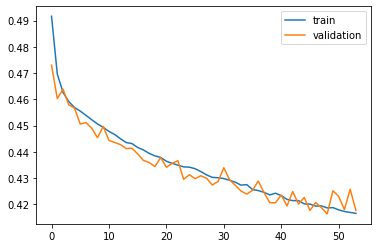

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
pred_df = pd.DataFrame(pred, columns= ['TAG'])

In [ ]:
pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x> 0.5 else 0)

In [ ]:
pred_df['TAG'].value_counts()

1    248479
0     82711
Name: TAG, dtype: int64

In [ ]:
pred_df['TAG2'] = test_label

In [ ]:
pred_df['TAG2'] = pred_df['TAG2'].apply(lambda x : 0 if x == 1 else 1)
pred_df

,TAG,TAG2
0,1,0
1,1,1
2,1,0
3,1,0
4,1,0
...,...,...
331185,1,0
331186,1,0
331187,1,0
331188,1,0


In [ ]:
classify = confusion_matrix(test_label, pred_df['TAG'])
print(classify)

[[  6602  17061]
 [ 76109 231418]]


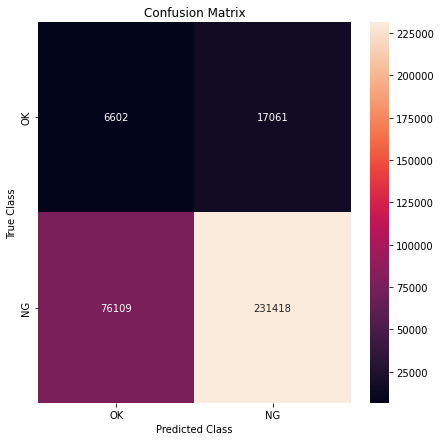

In [ ]:
plt.figure(figsize=(7, 7))
sns.heatmap(classify, xticklabels=['OK', 'NG'], yticklabels=['OK', 'NG'], annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

In [ ]:
p = precision_score(test_label, pred_df['TAG'])
print("precision : %0.4f" %p)
r = recall_score(test_label, pred_df['TAG'])
print("recall : %0.4f" %r)
f1 = f1_score(test_label, pred_df['TAG'])
print("f1-score : %0.4f" %f1)
acc = accuracy_score(test_label,pred_df['TAG'])
print("recall : %0.4f" %acc)

precision : 0.9313
recall : 0.7525
f1-score : 0.8324
recall : 0.7187


In [ ]:
df_result = pred_df.copy()
df_result.rename(columns = {'TAG' : 'pred'}, inplace = True)